<a href="https://colab.research.google.com/github/Ritanjit/Text_Sentiment_Classification/blob/main/Sentiment_Classification_Twitter_Text_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Imports and Configuration
import warnings
warnings.filterwarnings("ignore")

import os
import time
import datetime

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import pandas as pd
import numpy as np

from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Device setup: GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Hyperparameters
MODEL_NAME = 'bert-base-uncased'  # Pretrained BERT model
MAX_LENGTH = 128                 # Tokenizer max length
BATCH_SIZE = 16                  # Batch size per GPU/CPU
LEARNING_RATE = 2e-5             # Learning rate for optimizer
EPSILON = 1e-8                   # Epsilon for AdamW
EPOCHS = 3                       # Number of training epochs

In [6]:
# Cell 2: Download and Load Dataset from Kagglehub
# Using kagglehub to fetch the Twitter entity sentiment dataset
import kagglehub
import os

# Download the dataset
dataset_path = kagglehub.dataset_download('jp797498e/twitter-entity-sentiment-analysis')  # dataset identifier

# Define input file paths using the downloaded dataset path
TRAIN_PATH = os.path.join(dataset_path, 'twitter_training.csv')
VALID_PATH = os.path.join(dataset_path, 'twitter_validation.csv')

# Load datasets with pandas
df_train = pd.read_csv(TRAIN_PATH, header=None, names=['TweetID', 'Entity', 'Sentiment', 'Text'], encoding='latin1')
df_valid = pd.read_csv(VALID_PATH, header=None, names=['TweetID', 'Entity', 'Sentiment', 'Text'], encoding='latin1')

print(f"Loaded {len(df_train)} training samples and {len(df_valid)} validation samples.")

Loaded 74682 training samples and 1000 validation samples.


In [7]:
# Cell 3: Data Cleaning and Label Mapping
# Drop samples with missing text or sentiment
df_train.dropna(subset=['Text', 'Sentiment'], inplace=True)
_df_valid = df_valid.dropna(subset=['Text', 'Sentiment'])  # _df_valid used for chaining

df_train['Text'] = df_train['Text'].astype(str)
df_valid['Text'] = df_valid['Text'].astype(str)

# Map sentiments to integer labels: {'Positive':0, 'Negative':1, 'Neutral':2}
sentiments = ['Positive', 'Negative', 'Neutral']
sentiment_map = {s: i for i, s in enumerate(sentiments)}

# Apply mapping; unknown labels will be filtered out
df_train = df_train[df_train['Sentiment'].isin(sentiments)]
df_valid = df_valid[df_valid['Sentiment'].isin(sentiments)]

df_train['Label'] = df_train['Sentiment'].map(sentiment_map)
df_valid['Label'] = df_valid['Sentiment'].map(sentiment_map)

print("Training label distribution:\n", df_train['Label'].value_counts())
print("Validation label distribution:\n", df_valid['Label'].value_counts())

Training label distribution:
 Label
1    22358
0    20655
2    18108
Name: count, dtype: int64
Validation label distribution:
 Label
2    285
0    277
1    266
Name: count, dtype: int64


In [8]:
# Cell 4: Tokenization
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Tokenize the text data
def tokenize_texts(texts):
    return tokenizer(
        texts,
        padding='max_length', truncation=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

train_encodings = tokenize_texts(df_train['Text'].tolist())
valid_encodings = tokenize_texts(df_valid['Text'].tolist())

# Convert labels to tensor
y_train = torch.tensor(df_train['Label'].values)
y_valid = torch.tensor(df_valid['Label'].values)

print(f"Tokenized training data shape: {train_encodings['input_ids'].shape}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenized training data shape: torch.Size([61121, 128])


In [9]:
# Cell 5: Dataset and DataLoader
class TweetSentimentDataset(Dataset):
    """Custom Dataset for sentiment classification"""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create dataset objects
dataset_train = TweetSentimentDataset(train_encodings, y_train)
dataset_valid = TweetSentimentDataset(valid_encodings, y_valid)

# Create DataLoaders
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=BATCH_SIZE)
dataloader_valid = DataLoader(dataset_valid, sampler=SequentialSampler(dataset_valid), batch_size=BATCH_SIZE)

print(f"Number of training batches: {len(dataloader_train)}")

Number of training batches: 3821


In [10]:
# Cell 6: Model Initialization
# Load pre-trained BERT model with classification head
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(sentiments),
    output_attentions=False,
    output_hidden_states=False
)
model.to(device)

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
total_steps = len(dataloader_train) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

print(f"Model loaded: {MODEL_NAME} with {len(sentiments)} labels.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: bert-base-uncased with 3 labels.


In [11]:
# Cell 7: Training Loop
# Helper function for formatting elapsed time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(elapsed)))

for epoch in range(EPOCHS):
    print(f"\n======== Epoch {epoch+1}/{EPOCHS} ========")
    # Training
    model.train()
    total_train_loss = 0
    start_time = time.time()

    for step, batch in enumerate(dataloader_train):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        if step % 50 == 0 and step > 0:
            elapsed = format_time(time.time() - start_time)
            print(f"  Batch {step}/{len(dataloader_train)} - Elapsed: {elapsed}")

    avg_train_loss = total_train_loss / len(dataloader_train)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    total_eval_loss = 0
    preds, true_labels = [], []

    for batch in dataloader_valid:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_eval_loss / len(dataloader_valid)
    val_accuracy = accuracy_score(true_labels, preds)

    print(f"Validation loss: {avg_val_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")


======== Epoch 1/3 ========
  Batch 50/3821 - Elapsed: 0:00:16
  Batch 100/3821 - Elapsed: 0:00:32
  Batch 150/3821 - Elapsed: 0:00:48
  Batch 200/3821 - Elapsed: 0:01:03
  Batch 250/3821 - Elapsed: 0:01:20
  Batch 300/3821 - Elapsed: 0:01:36
  Batch 350/3821 - Elapsed: 0:01:52
  Batch 400/3821 - Elapsed: 0:02:09
  Batch 450/3821 - Elapsed: 0:02:26
  Batch 500/3821 - Elapsed: 0:02:42
  Batch 550/3821 - Elapsed: 0:02:59
  Batch 600/3821 - Elapsed: 0:03:15
  Batch 650/3821 - Elapsed: 0:03:32
  Batch 700/3821 - Elapsed: 0:03:48
  Batch 750/3821 - Elapsed: 0:04:05
  Batch 800/3821 - Elapsed: 0:04:21
  Batch 850/3821 - Elapsed: 0:04:38
  Batch 900/3821 - Elapsed: 0:04:55
  Batch 950/3821 - Elapsed: 0:05:11
  Batch 1000/3821 - Elapsed: 0:05:28
  Batch 1050/3821 - Elapsed: 0:05:44
  Batch 1100/3821 - Elapsed: 0:06:01
  Batch 1150/3821 - Elapsed: 0:06:17
  Batch 1200/3821 - Elapsed: 0:06:34
  Batch 1250/3821 - Elapsed: 0:06:50
  Batch 1300/3821 - Elapsed: 0:07:07
  Batch 1350/3821 - Elapsed: 

In [12]:
# Cell 8: Evaluation
print("\n--- Final Classification Report ---")
print(classification_report(true_labels, preds, target_names=sentiments, digits=4))


--- Final Classification Report ---
              precision    recall  f1-score   support

    Positive     0.9783    0.9783    0.9783       277
    Negative     0.9848    0.9737    0.9792       266
     Neutral     0.9722    0.9825    0.9773       285

    accuracy                         0.9783       828
   macro avg     0.9785    0.9782    0.9783       828
weighted avg     0.9783    0.9783    0.9783       828



In [13]:
# Cell 9: Model Saving
# Save the trained model and tokenizer for future inference
output_dir = 'saved_model'
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}/")

Model and tokenizer saved to saved_model/


In [14]:
# Cell 10: Testing and Inference
# Load saved model and tokenizer for inference on custom samples
from transformers import BertForSequenceClassification, BertTokenizer
saved_tokenizer = BertTokenizer.from_pretrained(output_dir)
saved_model = BertForSequenceClassification.from_pretrained(output_dir)
saved_model.to(device)
saved_model.eval()

# Define helper for prediction
def predict_sentiment(text):
    enc = saved_tokenizer(text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors='pt')
    input_ids = enc['input_ids'].to(device)
    attention_mask = enc['attention_mask'].to(device)
    with torch.no_grad():
        logits = saved_model(input_ids, attention_mask=attention_mask).logits
    pred = torch.argmax(logits, dim=1).item()
    return sentiments[pred]

# Test on custom examples
samples = [
    "I love this product! It exceeded my expectations.",
    "This is the worst service I have ever used.",
    "The event was okay, nothing special."
]
for text in samples:
    print(f"Text: {text}\nPredicted sentiment: {predict_sentiment(text)}\n")

Text: I love this product! It exceeded my expectations.
Predicted sentiment: Positive

Text: This is the worst service I have ever used.
Predicted sentiment: Negative

Text: The event was okay, nothing special.
Predicted sentiment: Neutral



Confusion Matrix:



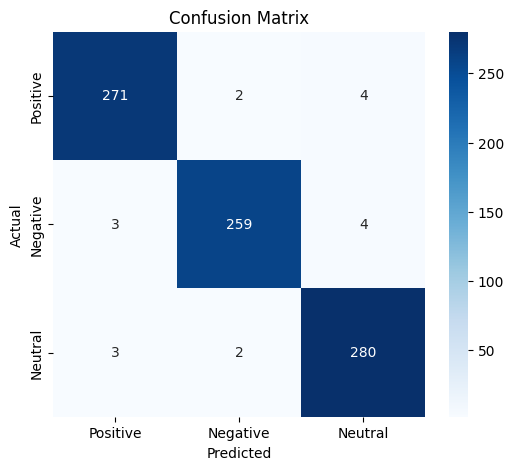

In [20]:
# Cell 11: Detailed Metrics and Confusion Matrix
# Calculate and display confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, preds)
print("Confusion Matrix:\n")

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiments, yticklabels=sentiments)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Cell 12: Misclassified Examples
# Display a few misclassified tweets for analysis
mis_idx = [i for i, (t, p) in enumerate(zip(true_labels, preds)) if t != p][:5]
for idx in mis_idx:
    print(f"Tweet: {df_valid.iloc[idx]['Text']}")
    print(f"True: {sentiments[true_labels[idx]]}, Pred: {sentiments[preds[idx]]}\n")

Tweet: The new @CallofDuty for ps5 is ð¥ð¥ð¥ð¥
Oh God ð­ð
True: Negative, Pred: Positive

Tweet: Leaked memo excoriates #Facebookâs âslapdash and haphazardâ response to global political manipulation dlvr.it/RgbzJD https://t.co/M7JAMQeF7e
True: Negative, Pred: Neutral

Tweet: #Indigo Urgent Care looks to Microsoft Teams and Microsoftâs Power Platform to help deliver quality care and world-class patient experience lnkd.in/eAzWmuB
True: Positive, Pred: Neutral

Tweet: Plague of Corruption is #1 on Amazon and # 3 on The NY Times bestseller list. pic.twitter.com/mr2gbN43I9
True: Negative, Pred: Positive

Tweet: #WorldCupAtHome: Five African matches you would love to see from FIFA googlehits.com/worldcupathomeâ¦ https://t.co/Lvr8g2vhsn
True: Positive, Pred: Neutral



In [18]:
# Cell 13: Save Model to Google Drive
# Mount Google Drive and copy saved model directory for persistent storage
from google.colab import drive
import shutil

drive.mount('/content/drive')  # Prompts for authentication

drive_output_dir = '/content/drive/MyDrive/sentiment_saved_model'
# Remove existing directory if exists
if os.path.exists(drive_output_dir):
    shutil.rmtree(drive_output_dir)
# Copy saved_model to Drive
shutil.copytree(output_dir, drive_output_dir)
print(f"Model and tokenizer copied to Google Drive at {drive_output_dir}")

Mounted at /content/drive
Model and tokenizer copied to Google Drive at /content/drive/MyDrive/sentiment_saved_model


In [24]:
# Cell 14: User Input for Live Prediction
# Prompt user for a custom sentence and predict its sentiment
user_input = input("Enter a sentence to classify sentiment: ")
prediction = predict_sentiment(user_input)
print(f"\nInput text: {user_input}\nPredicted sentiment: {prediction}")

Enter a sentence to classify sentiment: I am a boy

Input text: I am a boy
Predicted sentiment: Neutral
